### Real-Time Prediction Pipeline with FinBERT and Random Forest

To simulate a real-time prediction of stock sentiment after an earnings call, this pipeline combines **FinBERT-based tone analysis**, **earnings surprise calculation**, and **firm size** to predict stock movement categories (Bullish, Bearish, Neutral). Management speech content is entered interactively by speaker, and FinBERT computes a weighted tone score across all speakers. These inputs are passed to a pre-trained **Random Forest classifier**, which returns the predicted sentiment category along with **confidence scores** for each class. This system enables dynamic, data-driven assessments of stock reactions based on earnings call tone and fundamentals.


In [ ]:
import os
import pandas as pd
import multiprocessing
import torch
from transformers import pipeline
import joblib
import json 


# Disable Hugging Face tokenizers parallelism to avoid multiprocessing conflicts
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set multiprocessing start method for macOS
multiprocessing.set_start_method("spawn", force=True)

# Check if MPS (Metal Performance Shaders) is available for acceleration
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Load FinBERT sentiment analysis pipeline with MPS acceleration
pipe = pipeline(
    "text-classification", model="ProsusAI/finbert", device=0 if device == "mps" else -1
)


def split_text(text, chunk_size=250, overlap=50):
    """Splits long text into overlapping chunks to fit FinBERT's token limit."""
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunks.append(" ".join(words[i : i + chunk_size]))
    return chunks


def get_sentiment_score(text):
    """Return the sentiment score (-1 to 1) using ProsusAI/FinBERT, handling long text."""
    chunks = split_text(text)  
    total_words = len(text.split())  
    sentiment_scores = []

    for i, chunk in enumerate(chunks):
        try:
            if len(chunk.split()) > 512:
                chunk = " ".join(
                    chunk.split()[:512]
                )  
            result = pipe(chunk)[0]  
            label = result["label"]
            score = result["score"]
            word_count = len(chunk.split())

            if label == "positive":
                sentiment_scores.append(score * word_count)
            elif label == "negative":
                sentiment_scores.append(-score * word_count)
            else:
                sentiment_scores.append(0)

        except Exception as e:
            print(f"Error processing chunk {i+1}: {e}")

    if total_words == 0:
        return 0, total_words 

    overall_sentiment = (
        sum(sentiment_scores) / total_words
    )  
    return overall_sentiment, total_words


def get_weighted_sentiment(speakers):
    """Computes the overall weighted sentiment score from multiple speakers."""
    total_words = 0
    weighted_score_sum = 0

    for speaker_key, speaker_data in speakers.items():
        speaker_name = speaker_data.get("name", speaker_key)
        text = speaker_data["content"]

        score, word_count = get_sentiment_score(text)

        # Accumulate total words and weighted score sum
        total_words += word_count
        weighted_score_sum += score * word_count

    # Compute final weighted sentiment score for the entire dataset
    if total_words > 0:
        return weighted_score_sum / total_words

    return None 


def calculate_earnings_surprise(actual, estimated):
    """Calculate earnings surprise percentage."""
    if estimated == 0:
        return None 
    return (actual - estimated) / estimated


def pipeline(actual, estimated, size, transcript):
    
    earnings_surprise = calculate_earnings_surprise(actual, estimated)
    
    tone = get_weighted_sentiment(transcript)
    
    # Load the model
    rf_model = joblib.load("random_forest_best_model.pkl")

    # New sample for prediction (must match training format)
    new_data = pd.DataFrame([[earnings_surprise, size, tone]], columns=["Earnings_Surprise", "Firm_Size", "method_2"])

    # Predict category
    predicted_category = rf_model.predict(new_data)[0]
    
    # Get confidence scores for each class
    confidence_scores = rf_model.predict_proba(new_data)[0]

    # Output results
    category_labels = rf_model.classes_
    confidence_dict = {category_labels[i]: confidence_scores[i] for i in range(len(category_labels))}

    return predicted_category, confidence_dict

def build_speaker_json():
    data = {}
    num_speakers = int(input("How many speakers? "))

    for i in range(1, num_speakers + 1):
        print(f"\n--- Speaker {i} ---")
        name = input("Enter speaker name: ")
        print("Enter speaker content (press ENTER twice to finish):")

        # Allow multi-line input until two Enters
        content_lines = []
        while True:
            line = input()
            if line == "":
                break
            content_lines.append(line)
        content = " ".join(content_lines)

        data[f"speaker{i}"] = {
            "name": name,
            "content": content
        }

    return data


if __name__ == "__main__":
    # Sample input formatted with speaker keys
    data = build_speaker_json()

    predicted_category, confidence_scores = pipeline(1.25, 0.94, 6089250000, data)

    print(f"Predicted Category: {predicted_category}")
    print("Confidence Scores per Category:")
    for category, score in confidence_scores.items():
        print(f"  {category}: {score * 100:.2f}%")




Device set to use mps:0


ValueError: invalid literal for int() with base 10: ''

### Live Trading Simulation with FinBERT-Tone Rule-Based Strategy

To evaluate the real-time profitability of FinBERT tone analysis, this simulation models an active trading strategy using **post-earnings sentiment predictions**. A virtual portfolio of 20 partitions starts with \$1,000,000 and updates daily based on **earnings calls and predicted tone categories**. Stocks labeled "Bullish" are bought, held, or replaced based on confidence thresholds, while "Bearish" and "Neutral" are ignored.

A **live performance plot** visualizes portfolio value, cash, and stock holdings against the **S&P 500 benchmark**. At the end of the simulation, financial metrics—including **CAGR**, **Sharpe Ratio**, **Alpha**, **Beta**, **R-squared**, and **Maximum Drawdown**—are computed to assess risk-adjusted returns and validate the effectiveness of the rule-based sentiment trading approach.



=== Trading Day: 2024-01-02 ===
Skipping earnings check - No previous trading day available.

=== Trading Day: 2024-01-03 ===

=== Trading Day: 2024-01-04 ===

=== Trading Day: 2024-01-05 ===
RPM: Predicted category - Neutral, Confidence: {'Bullish': 0.0, 'Bearish': 0.0, 'Neutral': 0.4766452588410207}

=== Trading Day: 2024-01-08 ===
STZ: Predicted category - Bullish, Confidence: {'Bullish': 0.62247289578422, 'Bearish': 0.0, 'Neutral': 0.0}
Part_1: Buying STZ based on pipeline prediction.
Part_1: Bought 201.49103364900262 shares of STZ at 248.15, remaining cash: 0.0

=== Trading Day: 2024-01-09 ===

=== Trading Day: 2024-01-10 ===

=== Trading Day: 2024-01-11 ===

=== Trading Day: 2024-01-12 ===

=== Trading Day: 2024-01-16 ===
WFC: Predicted category - Bearish, Confidence: {'Bullish': 0.0, 'Bearish': 0.0841768121257812, 'Neutral': 0.0}
BAC: Predicted category - Bearish, Confidence: {'Bullish': 0.0, 'Bearish': -0.08192540659646143, 'Neutral': 0.0}
C: Predicted category - Neutral, Conf

/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/ipykernel_21676/4104437003.py:225: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = animation.FuncAnimation(self.fig, self.update_plot, fargs=(experiment,), interval=500)


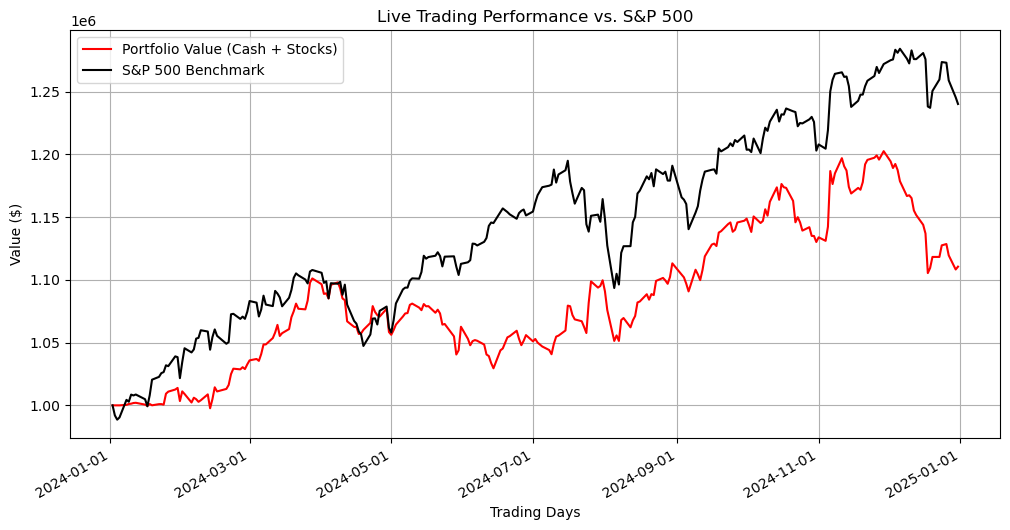


=== Trade Log ===
{'action': 'BUY', 'date': Timestamp('2024-01-08 00:00:00'), 'stock': 'STZ', 'price': 248.15, 'position': 201.49103364900262, 'partition': 'Part_1'}
{'action': 'BUY', 'date': Timestamp('2024-01-16 00:00:00'), 'stock': 'DAL', 'price': 38.14, 'position': 1310.9596224436286, 'partition': 'Part_2'}
{'action': 'BUY', 'date': Timestamp('2024-01-22 00:00:00'), 'stock': 'SLB', 'price': 49.56, 'position': 1008.8781275221953, 'partition': 'Part_3'}
{'action': 'BUY', 'date': Timestamp('2024-01-22 00:00:00'), 'stock': 'TRV', 'price': 212.74, 'position': 235.02867349816677, 'partition': 'Part_4'}
{'action': 'BUY', 'date': Timestamp('2024-01-22 00:00:00'), 'stock': 'HBAN', 'price': 12.83, 'position': 3897.116134060795, 'partition': 'Part_5'}
{'action': 'BUY', 'date': Timestamp('2024-01-24 00:00:00'), 'stock': 'VZ', 'price': 42.23, 'position': 1183.9924224484964, 'partition': 'Part_6'}
{'action': 'BUY', 'date': Timestamp('2024-01-24 00:00:00'), 'stock': 'ABT', 'price': 110.75, 'posi

In [ ]:
import json
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


class TradingExperiment:
    def __init__(self, initial_fund=1_000_000, num_partitions=20):
        self.initial_fund = initial_fund
        self.num_partitions = num_partitions
        self.trading_days = []
        self.live_plot = None

        self.portfolio = {
            f"Part_{i+1}": {
                "stock": None,
                "position": 0,
                "buy_date": None,
                "cash": initial_fund / num_partitions,
                "category": None,
                "confidence": None
            }
            for i in range(num_partitions)
        }

        self.trade_log = []
        
    def load_trading_days(self, json_file):
        with open(json_file, "r") as file:
            data = json.load(file)
        self.trading_days = sorted(pd.to_datetime([entry["date"] for entry in data["historical"] if "2024" in entry["date"]]))

    def get_previous_trading_day(self, current_day):
        index = self.trading_days.index(current_day)
        return self.trading_days[index - 1] if index > 0 else None
    
    def simulate_trading(self, decision_function):
        """
        Runs the trading simulation with live plotting.
        - **Sells first** before executing buy orders.
        - Updates portfolio dynamically.
        """
        self.live_plot = LivePlot(self.trading_days)

        for current_day in self.trading_days:
            print(f"\n=== Trading Day: {current_day.date()} ===")

            # Get previous trading day
            previous_day = self.get_previous_trading_day(current_day)

            # Check if previous_day is None before calling check_earning_call()
            if previous_day is None:
                print("Skipping earnings check - No previous trading day available.")
                earnings_instances = [] 
            else:
                earnings_instances = check_earning_call(previous_day)

            processed_stocks = {}

            if earnings_instances:
                for instance in earnings_instances:
                    stock = instance["Stock"]
                    transcript = instance["Earnings_Call_Transcript"]

                    category, confidence_scores = pipeline1(transcript)

                    processed_stocks[stock] = {
                        "category": category,
                        "confidence": confidence_scores
                    }

                    print(f"{stock}: Predicted category - {category}, Confidence: {confidence_scores}")

            # Get trading decisions 
            decisions = decision_function(self.portfolio, current_day, processed_stocks)

            ### --- SELL ORDERS FIRST --- ###
            for action in decisions:
                if action["action"] == "SELL":
                    part = action["partition"]
                    stock = action["stock"]
                    sell_price = action["sell_price"]

                    value = sell(stock, current_day, self.portfolio[part]["position"], sell_price)
                    if value:
                        self.portfolio[part] = {
                            "stock": None,
                            "position": 0,
                            "buy_date": None,
                            "cash": self.portfolio[part]["cash"] + value,  
                            "category": None,
                            "confidence": None
                        }
                        self.trade_log.append({
                            "action": "SELL",
                            "date": current_day,
                            "stock": stock,
                            "return_value": value,
                            "partition": part
                        })
                        print(f"{part}: Sold {stock} for {value}, new cash balance: {self.portfolio[part]['cash']}")

            ### --- BUY ORDERS AFTER SELLING --- ###
            for action in decisions:
                if action["action"] == "BUY":
                    part = action["partition"]
                    stock = action["stock"]
                    category = action["category"]
                    confidence = action["confidence"]

                    price, position = buy(stock, current_day, self.portfolio[part]["cash"], "open")
                    if price and position:
                        invested_amount = price * position
                        self.portfolio[part] = {
                            "stock": stock,
                            "position": position,
                            "buy_date": current_day,
                            "cash": self.portfolio[part]["cash"] - invested_amount, 
                            "category": category,
                            "confidence": confidence
                        }
                        self.trade_log.append({
                            "action": "BUY",
                            "date": current_day,
                            "stock": stock,
                            "price": price,
                            "position": position,
                            "partition": part
                        })
                        print(f"{part}: Bought {position} shares of {stock} at {price}, remaining cash: {self.portfolio[part]['cash']}")

            # Update the live plot
            self.live_plot.update_plot(None, self)

        # Start live animation
        self.live_plot.animate(self)



    def print_trade_log(self):
        """Prints all trade transactions."""
        print("\n=== Trade Log ===")
        for log in self.trade_log:
            print(log)


class LivePlot:
    def __init__(self, trading_days):
        import matplotlib.dates as mdates  

        self.trading_days = trading_days
        self.current_index = 0
        self.portfolio_values = []
        self.cash_values = []
        self.stock_values = []
        self.sp500_values = []
        self.portfolio_returns = []
        self.sp500_returns = []
        self.initial_fund = 1_000_000
        self.sp500_start_price = None

        self.fig, self.ax = plt.subplots(figsize=(12, 6))
        self.lines = {}
        self.lines["portfolio"], = self.ax.plot([], [], "r-", label="Portfolio Value (Cash + Stocks)")
        self.lines["sp500"], = self.ax.plot([], [], "k-", label="S&P 500 Benchmark")

        self.ax.set_xlabel("Trading Days")
        self.ax.set_ylabel("Value ($)")
        self.ax.set_title("Live Trading Performance vs. S&P 500")
        self.ax.legend()
        self.ax.grid()

        #  Date formatting for x-axis
        self.ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        self.ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        self.fig.autofmt_xdate()


    def update_plot(self, i, experiment):
        if self.current_index >= len(self.trading_days):
            return

        current_day = self.trading_days[self.current_index]
        self.current_index += 1

        total_cash = sum(part["cash"] for part in experiment.portfolio.values())
        total_stock_value = 0

        for part in experiment.portfolio.values():
            if part["stock"]:
                stock_price = get_stock_price(part["stock"], current_day, "close")
                if stock_price:
                    total_stock_value += part["position"] * stock_price

        sp500_close = get_S_and_P_value(current_day)
        if self.sp500_start_price is None and sp500_close is not None:
            self.sp500_start_price = sp500_close

        total_portfolio_value = total_cash + total_stock_value
        sp500_value = (self.initial_fund / self.sp500_start_price) * sp500_close if self.sp500_start_price else None

        self.portfolio_values.append(total_portfolio_value)
        self.cash_values.append(total_cash)
        self.stock_values.append(total_stock_value)
        self.sp500_values.append(sp500_value)

        if self.current_index > 1:
            port_ret = (self.portfolio_values[-1] - self.portfolio_values[-2]) / self.portfolio_values[-2]
            sp500_ret = (self.sp500_values[-1] - self.sp500_values[-2]) / self.sp500_values[-2]
            self.portfolio_returns.append(port_ret)
            self.sp500_returns.append(sp500_ret)

        self.lines["portfolio"].set_data(self.trading_days[:self.current_index], self.portfolio_values)
        if sp500_value:
            self.lines["sp500"].set_data(self.trading_days[:self.current_index], self.sp500_values)

        self.ax.relim()
        self.ax.autoscale_view()
        plt.draw()

    def animate(self, experiment):
        self.ani = animation.FuncAnimation(self.fig, self.update_plot, fargs=(experiment,), interval=500)
        plt.show()


def buy(stock, date, fund, time):
    """
    Simulates buying a stock by fetching the appropriate price from the stock's daily chart JSON file.

    Parameters:
        stock (str): The stock symbol (folder name).
        date (str): The trading date (format: YYYY-MM-DD).
        fund (float): The amount of money available to buy the stock.
        time (str): "open" or "close" to decide which price to use.

    Returns:
        tuple: (price, position) - price per share and number of shares bought.
    """
    date = pd.to_datetime(date).strftime("%Y-%m-%d")  
    
    # Define the expected file path
    stock_folder = os.path.join(os.getcwd(), stock) 
    file_path = os.path.join(stock_folder, "daily_chart_2019_2024.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None, None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    # Get the requested price type (open/close)
    entry = historical_data[date]
    price = entry.get(time.lower())

    if price is None:
        print(f"Error: Missing {time} price for {stock} on {date}")
        return None

    # Calculate position (number of shares bought)
    position = fund / price if price > 0 else 0

    return price, position


def sell(stock, date, position, time):
    """
    Simulates selling a stock by fetching the appropriate price from the stock's daily chart JSON file.

    Parameters:
        stock (str): The stock symbol (folder name).
        date (str): The trading date (format: YYYY-MM-DD).
        position (float): Number of shares being sold.
        time (str): "open" or "close" to decide which price to use.

    Returns:
        float: Total return from selling the stock.
    """
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the expected file path
    stock_folder = os.path.join(os.getcwd(), stock)  
    file_path = os.path.join(stock_folder, "daily_chart_2019_2024.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    # Get the requested price type (open/close)
    entry = historical_data[date]
    price = entry.get(time.lower())

    if price is None:
        print(f"Error: Missing {time} price for {stock} on {date}")
        return None

    # Calculate return value from selling
    return_value = position * price

    return return_value


def get_stock_price(stock, date, time):
    """
    Fetches stock price from JSON file.

    Parameters:
        stock (str): Stock symbol.
        date (str): Trading date (YYYY-MM-DD).
        time (str): "open" or "close".

    Returns:
        float: Price per share.
    """
    date = pd.to_datetime(date).strftime("%Y-%m-%d")
    file_path = os.path.join(os.getcwd(), stock, "daily_chart_2019_2024.json")

    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None

    with open(file_path, "r") as file:
        data = json.load(file)

    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    return historical_data[date].get(time.lower())


def close(stock, date, position):
    """
    Retrieves the stock's closing price from the stock's daily chart JSON file and calculates the final value.

    Parameters:
        stock (str): The stock symbol (folder name).
        date (str): The trading date (format: YYYY-MM-DD).
        position (float): Number of shares being sold.

    Returns:
        float: Total value from selling at closing price.
    """
    # Ensure date format is correct
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the expected file path
    stock_folder = os.path.join(os.getcwd(), stock)  
    file_path = os.path.join(stock_folder, "daily_chart_2019_2024.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    # Get the closing price
    close_price = historical_data[date].get("close")

    if close_price is None:
        print(f"Error: Missing closing price for {stock} on {date}")
        return None

    # Calculate return value from forced sell
    value = position * close_price

    return value


def check_earning_call(date):
    """
    Checks the '2024_trading.csv' file and returns rows where Earnings_Call_Date matches the given date.

    Parameters:
        date (str): The date to check for earnings calls (format: YYYY-MM-DD).

    Returns:
        list: A list of dictionaries containing earnings call data for the given date.
    """
    # Ensure the date format is correct
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the file path
    file_path = os.path.join(os.getcwd(), "2024_trading.csv")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Earnings data file not found at {file_path}")
        return None

    # Load CSV file
    df = pd.read_csv(file_path, dtype=str) 

    # Ensure the date column is in correct format
    df["Earnings_Call_Date"] = pd.to_datetime(df["Earnings_Call_Date"], errors="coerce").dt.strftime("%Y-%m-%d")

    # Filter rows where Earnings_Call_Date matches the given date
    matching_rows = df[df["Earnings_Call_Date"] == date]

    # If no matches found, return None
    if matching_rows.empty:
        return None

    # Convert dataframe to list of dictionaries
    instances = matching_rows.to_dict(orient="records")

    for instance in instances:
        # Convert transcript string back to dictionary
        try:
            instance["Earnings_Call_Transcript"] = json.loads(instance["Earnings_Call_Transcript"])
        except json.JSONDecodeError:
            print(f"Error decoding JSON for transcript of stock {instance['Stock']}. Using raw string.")

        # Convert earnings fields to float
        try:
            instance["Actual_Earning"] = float(instance["Actual_Earning"])
            instance["Estimated_Earning"] = float(instance["Estimated_Earning"])
        except ValueError:
            print(f"Error converting earnings for stock {instance['Stock']}. Using default value 0.")
            instance["Actual_Earning"] = 0.0
            instance["Estimated_Earning"] = 0.0

    return instances


def get_S_and_P_value(date):
    """
    Retrieves the S&P 500 closing price for a given date from 'S&P_500_price.json'.

    Parameters:
        date (str): The date to get the closing price for (format: YYYY-MM-DD).

    Returns:
        float: Closing price of S&P 500 for the given date, or None if not found.
    """
    # Ensure the date format is correct
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the file path
    file_path = os.path.join(os.getcwd(), "S&P_500_price.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: S&P 500 data file not found at {file_path}")
        return None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No S&P 500 price data found for {date}")
        return None

    # Get the closing price
    close_price = historical_data[date].get("close")

    if close_price is None:
        print(f"Error: Missing closing price for S&P 500 on {date}")
        return None

    return close_price


def split_text(text, chunk_size=250, overlap=50):
    """Splits long text into overlapping chunks to fit FinBERT's token limit."""
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunks.append(" ".join(words[i : i + chunk_size]))
    return chunks


def get_sentiment_score(text):
    """Return the sentiment score (-1 to 1) using ProsusAI/FinBERT, handling long text."""
    chunks = split_text(text)  
    total_words = len(text.split()) 
    sentiment_scores = []

    for i, chunk in enumerate(chunks):
        try:
            if len(chunk.split()) > 512:
                chunk = " ".join(
                    chunk.split()[:512]
                ) 
            result = pipe(chunk)[0]  
            label = result["label"]
            score = result["score"]
            word_count = len(chunk.split())

            if label == "positive":
                sentiment_scores.append(score * word_count)
            elif label == "negative":
                sentiment_scores.append(-score * word_count)
            else:
                sentiment_scores.append(0)

        except Exception as e:
            print(f"Error processing chunk {i+1}: {e}")

    if total_words == 0:
        return 0, total_words 

    overall_sentiment = (
        sum(sentiment_scores) / total_words
    )  # Weighted average sentiment
    return overall_sentiment, total_words


def get_weighted_sentiment(speakers):
    """Computes the overall weighted sentiment score from multiple speakers."""
    total_words = 0
    weighted_score_sum = 0

    for speaker_key, speaker_data in speakers.items():
        speaker_name = speaker_data.get("name", speaker_key)
        text = speaker_data["content"]

        score, word_count = get_sentiment_score(text)

        # Accumulate total words and weighted score sum
        total_words += word_count
        weighted_score_sum += score * word_count

    # Compute final weighted sentiment score for the entire dataset
    if total_words > 0:
        return weighted_score_sum / total_words

    return None  


def pipeline1(transcript):
    # Step 1: Calculate inputs
    tone = get_weighted_sentiment(transcript)

    # Step 2: Rule-based classification using tone thresholds
    if tone > 0.5230:
        predicted_category = "Bullish"
        confidence_dict = {"Bullish": tone, "Bearish": 0.0, "Neutral": 0.0}
    elif tone < 0.2133:
        predicted_category = "Bearish"
        confidence_dict = {"Bullish": 0.0, "Bearish": tone, "Neutral": 0.0}
    else:
        predicted_category = "Neutral"
        confidence_dict = {"Bullish": 0.0, "Bearish": 0.0, "Neutral": tone}

    # Step 3: Return prediction and confidence
    return predicted_category, confidence_dict


def decision_function(portfolio, current_day, processed_stocks):
    """
    Trading decision logic based **only** on pipeline() predictions.
    - Holds stocks until their next earnings call.
    - Replaces only if confidence drops significantly.
    - Ensures only **one buy action per partition per day**.

    Parameters:
        portfolio (dict): The current portfolio state.
        current_day (datetime): The current trading day.
        processed_stocks (dict): Pipeline predictions with category & confidence.

    Returns:
        list: A list of trade actions (BUY or SELL).
    """
    actions = []
    confidence_threshold = 0.05  # Minimum confidence drop required for replacement
    processed_partitions = set()  # **Tracks partitions that already executed a buy to prevent double-buying**

    # Extract stock data from pipeline predictions
    bullish_stocks = {}

    for stock, data in processed_stocks.items():
        category = data["category"]
        confidence = data["confidence"].get(category, 0)  

        # **Only track Bullish stocks now**
        if category == "Bullish":
            bullish_stocks[stock] = (confidence, category)

    # Track available partitions for immediate buying
    available_partitions = [part for part in portfolio if portfolio[part]["stock"] is None]

    # 1. **Check if Current Holdings Have a New Earnings Call & Replace if Needed**
    for part, data in portfolio.items():
        if data["stock"] is not None:
            stock = data["stock"]

            # Check if this stock reappears in the earnings call
            if stock in bullish_stocks:
                new_confidence, new_category = bullish_stocks[stock]

                # **Check if confidence has dropped significantly**
                if new_confidence < data["confidence"] - confidence_threshold:
                    actions.append({"partition": part, "action": "SELL", "stock": stock, "sell_price": "open"})
                    actions.append({"partition": part, "action": "BUY", "stock": stock, "category": new_category, "confidence": new_confidence})
                    processed_partitions.add(part) 
                    print(f"{part}: Replacing {stock} due to confidence drop (Old: {data['confidence']}, New: {new_confidence})")

                # **If confidence is stable, keep holding**
                else:
                    print(f"{part}: Holding {stock} (Confidence stable: {new_confidence})")
                
                # Remove the stock from the available buy list
                bullish_stocks.pop(stock)

    # 2. **If there are empty partitions and Bullish stocks available → Fill them all**
    if available_partitions and bullish_stocks:
        for i in range(min(len(available_partitions), len(bullish_stocks))):  
            part = available_partitions[i]
            if part not in processed_partitions:  
                stock, (confidence, category) = bullish_stocks.popitem()
                actions.append({"partition": part, "action": "BUY", "stock": stock, "category": category, "confidence": confidence})
                processed_partitions.add(part)
                print(f"{part}: Buying {stock} based on pipeline prediction.")

    return actions


def calculate_performance_metrics(
    portfolio_values, sp500_values, portfolio_returns, sp500_returns,
    trading_days, risk_free_rate=0.05
):

    # Convert to numpy arrays
    portfolio_values = np.array(portfolio_values)
    sp500_values = np.array(sp500_values)
    portfolio_returns = np.array(portfolio_returns)
    sp500_returns = np.array(sp500_returns)

    # Use actual date range to compute number of years
    start_date = pd.to_datetime(trading_days[0])
    end_date = pd.to_datetime(trading_days[len(portfolio_returns)]) 
    total_days = (end_date - start_date).days
    actual_years = total_days / 365.25

    # === Portfolio Metrics ===
    total_return = portfolio_values[-1] / portfolio_values[0]
    cagr = total_return ** (1 / actual_years) - 1

    portfolio_volatility = np.std(portfolio_returns) * np.sqrt(252)
    sharpe_ratio = (np.mean(portfolio_returns) * 252 - risk_free_rate) / portfolio_volatility

    # Max Drawdown
    rolling_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    # === Benchmark Metrics ===
    sp500_total_return = sp500_values[-1] / sp500_values[0]
    sp500_cagr = sp500_total_return ** (1 / actual_years) - 1

    sp500_volatility = np.std(sp500_returns) * np.sqrt(252)
    sp500_sharpe = (np.mean(sp500_returns) * 252 - risk_free_rate) / sp500_volatility

    sp500_rolling_max = np.maximum.accumulate(sp500_values)
    sp500_drawdowns = (sp500_values - sp500_rolling_max) / sp500_rolling_max
    sp500_max_drawdown = sp500_drawdowns.min()

    return {
        # Portfolio
        "Portfolio CAGR": cagr,
        "Portfolio Sharpe Ratio": sharpe_ratio,
        "Portfolio Max Drawdown": max_drawdown,
        "Portfolio Volatility": portfolio_volatility,

        # Benchmark
        "S&P 500 CAGR": sp500_cagr,
        "S&P 500 Sharpe Ratio": sp500_sharpe,
        "S&P 500 Max Drawdown": sp500_max_drawdown,
        "S&P 500 Volatility": sp500_volatility,
    }



# Final evaluation (after simulation):
if __name__ == "__main__":
    json_file = "S&P_500_price.json"
    experiment = TradingExperiment()
    experiment.load_trading_days(json_file)
    experiment.simulate_trading(decision_function)
    experiment.print_trade_log()

    metrics = calculate_performance_metrics(
        experiment.live_plot.portfolio_values,
        experiment.live_plot.sp500_values,
        experiment.live_plot.portfolio_returns,
        experiment.live_plot.sp500_returns,
        experiment.trading_days
    )

    print("\n=== Portfolio Performance ===")
    for key, value in metrics.items():
        if "Portfolio" in key:
            print(f"{key}: {value:.4f}")

    print("\n=== S&P 500 Benchmark Performance ===")
    for key, value in metrics.items():
        if "S&P" in key:
            print(f"{key}: {value:.4f}")



### FinBERT-RandomForest Trading Simulation vs. S&P 500 Benchmark

To evaluate the performance of a **machine learning-based trading system**, this simulation integrates FinBERT-derived tone sentiment, earnings surprises, and firm size to make daily trading decisions using a **Random Forest classifier**. The portfolio is divided into 20 partitions and dynamically rebalanced based on updated predictions at each earnings call.

The strategy is benchmarked against the **S&P 500 index** with live visualization of portfolio value, stock holdings, cash, and benchmark progression. After the simulation, a set of key financial metrics—**CAGR**, **Sharpe Ratio**, **Alpha**, **Beta**, **R-squared**, **Maximum Drawdown**, and **Volatility**—are computed for both the portfolio and the benchmark. This provides a robust comparison of **risk-adjusted performance** and highlights the potential of tone-driven trading strategies.



=== Trading Day: 2024-01-02 ===
Skipping earnings check - No previous trading day available.

=== Trading Day: 2024-01-03 ===

=== Trading Day: 2024-01-04 ===

=== Trading Day: 2024-01-05 ===
RPM: Predicted category - Bullish, Confidence: {'Bearish': 0.003, 'Bullish': 0.981, 'Neutral': 0.016}
Part_1: Buying RPM based on pipeline prediction.
Part_1: Bought 483.65254401238155 shares of RPM at 103.38, remaining cash: 0.0

=== Trading Day: 2024-01-08 ===
STZ: Predicted category - Bearish, Confidence: {'Bearish': 0.934, 'Bullish': 0.0, 'Neutral': 0.066}

=== Trading Day: 2024-01-09 ===

=== Trading Day: 2024-01-10 ===

=== Trading Day: 2024-01-11 ===

=== Trading Day: 2024-01-12 ===

=== Trading Day: 2024-01-16 ===
WFC: Predicted category - Neutral, Confidence: {'Bearish': 0.367, 'Bullish': 0.005, 'Neutral': 0.628}
BAC: Predicted category - Neutral, Confidence: {'Bearish': 0.41242708333333333, 'Bullish': 0.00340625, 'Neutral': 0.5841666666666666}
C: Predicted category - Neutral, Confidence

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


KMI: Predicted category - Bearish, Confidence: {'Bearish': 0.634, 'Bullish': 0.113, 'Neutral': 0.253}
USB: Predicted category - Bearish, Confidence: {'Bearish': 0.9380526315789474, 'Bullish': 0.00031578947368421053, 'Neutral': 0.06163157894736842}
CFG: Predicted category - Bullish, Confidence: {'Bearish': 0.003, 'Bullish': 0.983, 'Neutral': 0.014}
SCHW: Predicted category - Bearish, Confidence: {'Bearish': 0.9651052631578948, 'Bullish': 0.001, 'Neutral': 0.03389473684210526}
PLD: Predicted category - Bearish, Confidence: {'Bearish': 0.9440155945419103, 'Bullish': 0.00031578947368421053, 'Neutral': 0.05566861598440546}
Part_3: Buying CFG based on pipeline prediction.
Part_3: Bought 1568.3814303638646 shares of CFG at 31.88, remaining cash: 0.0

=== Trading Day: 2024-01-19 ===
FAST: Predicted category - Neutral, Confidence: {'Bearish': 0.00505, 'Bullish': 0.0002, 'Neutral': 0.99475}
TFC: Predicted category - Neutral, Confidence: {'Bearish': 0.013, 'Bullish': 0.051, 'Neutral': 0.936}
JBHT

/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/ipykernel_21676/2444223922.py:228: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = animation.FuncAnimation(self.fig, self.update_plot, fargs=(experiment,), interval=500)


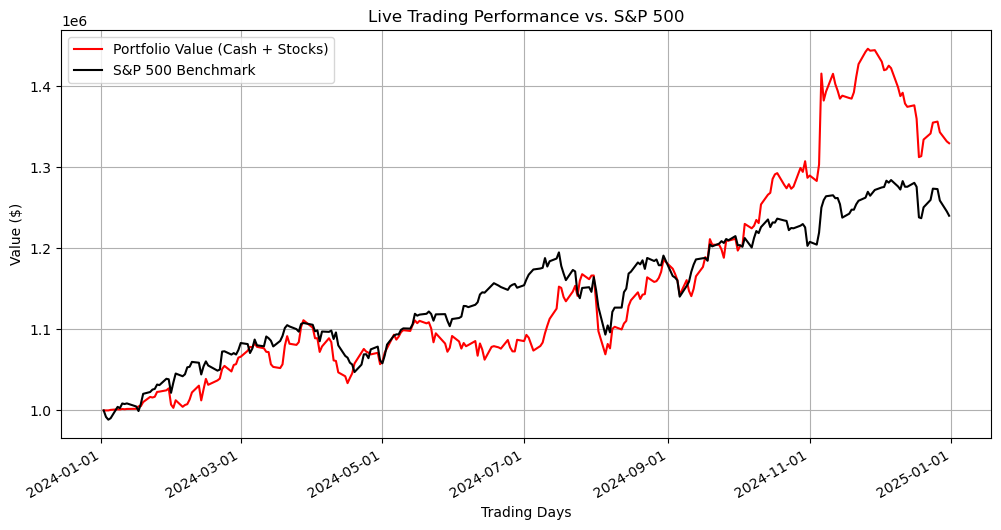


=== Trade Log ===
{'action': 'BUY', 'date': Timestamp('2024-01-05 00:00:00'), 'stock': 'RPM', 'price': 103.38, 'position': 483.65254401238155, 'partition': 'Part_1'}
{'action': 'BUY', 'date': Timestamp('2024-01-17 00:00:00'), 'stock': 'IBKR', 'price': 84.15, 'position': 594.1770647653, 'partition': 'Part_2'}
{'action': 'BUY', 'date': Timestamp('2024-01-18 00:00:00'), 'stock': 'CFG', 'price': 31.88, 'position': 1568.3814303638646, 'partition': 'Part_3'}
{'action': 'BUY', 'date': Timestamp('2024-01-19 00:00:00'), 'stock': 'KEY', 'price': 13.23, 'position': 3779.289493575208, 'partition': 'Part_4'}
{'action': 'BUY', 'date': Timestamp('2024-01-19 00:00:00'), 'stock': 'MTB', 'price': 133.29, 'position': 375.12191462225223, 'partition': 'Part_5'}
{'action': 'BUY', 'date': Timestamp('2024-01-19 00:00:00'), 'stock': 'DFS', 'price': 97.49, 'position': 512.8731151913017, 'partition': 'Part_6'}
{'action': 'BUY', 'date': Timestamp('2024-01-19 00:00:00'), 'stock': 'JBHT', 'price': 204.1, 'position

In [ ]:
import json
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


class TradingExperiment:
    def __init__(self, initial_fund=1_000_000, num_partitions=20):
        self.initial_fund = initial_fund
        self.num_partitions = num_partitions
        self.trading_days = []
        self.live_plot = None

        self.portfolio = {
            f"Part_{i+1}": {
                "stock": None,
                "position": 0,
                "buy_date": None,
                "cash": initial_fund / num_partitions,
                "category": None,
                "confidence": None
            }
            for i in range(num_partitions)
        }

        self.trade_log = []
        
    def load_trading_days(self, json_file):
        with open(json_file, "r") as file:
            data = json.load(file)
        self.trading_days = sorted(pd.to_datetime([entry["date"] for entry in data["historical"] if "2024" in entry["date"]]))

    def get_previous_trading_day(self, current_day):
        index = self.trading_days.index(current_day)
        return self.trading_days[index - 1] if index > 0 else None
    
    def simulate_trading(self, decision_function):
        """
        Runs the trading simulation with live plotting.
        - **Sells first** before executing buy orders.
        - Updates portfolio dynamically.
        """
        self.live_plot = LivePlot(self.trading_days)

        for current_day in self.trading_days:
            print(f"\n=== Trading Day: {current_day.date()} ===")

            # Get previous trading day
            previous_day = self.get_previous_trading_day(current_day)

            # Check if previous_day is None before calling check_earning_call()
            if previous_day is None:
                print("Skipping earnings check - No previous trading day available.")
                earnings_instances = [] 
            else:
                earnings_instances = check_earning_call(previous_day)

            processed_stocks = {}

            if earnings_instances:
                for instance in earnings_instances:
                    stock = instance["Stock"]
                    actual = instance["Actual_Earning"]
                    estimated = instance["Estimated_Earning"]
                    size = instance["Market_Cap"]
                    transcript = instance["Earnings_Call_Transcript"]

                    category, confidence_scores = pipeline2(actual, estimated, size, transcript)

                    processed_stocks[stock] = {
                        "category": category,
                        "confidence": confidence_scores
                    }

                    print(f"{stock}: Predicted category - {category}, Confidence: {confidence_scores}")

            # Get trading decisions (Pass `get_previous_trading_day` function to use it inside)
            decisions = decision_function(self.portfolio, current_day, processed_stocks)

            ### --- SELL ORDERS FIRST --- ###
            for action in decisions:
                if action["action"] == "SELL":
                    part = action["partition"]
                    stock = action["stock"]
                    sell_price = action["sell_price"]

                    value = sell(stock, current_day, self.portfolio[part]["position"], sell_price)
                    if value:
                        self.portfolio[part] = {
                            "stock": None,
                            "position": 0,
                            "buy_date": None,
                            "cash": self.portfolio[part]["cash"] + value, 
                            "category": None,
                            "confidence": None
                        }
                        self.trade_log.append({
                            "action": "SELL",
                            "date": current_day,
                            "stock": stock,
                            "return_value": value,
                            "partition": part
                        })
                        print(f"{part}: Sold {stock} for {value}, new cash balance: {self.portfolio[part]['cash']}")

            ### --- BUY ORDERS AFTER SELLING --- ###
            for action in decisions:
                if action["action"] == "BUY":
                    part = action["partition"]
                    stock = action["stock"]
                    category = action["category"]
                    confidence = action["confidence"]

                    price, position = buy(stock, current_day, self.portfolio[part]["cash"], "open")
                    if price and position:
                        invested_amount = price * position
                        self.portfolio[part] = {
                            "stock": stock,
                            "position": position,
                            "buy_date": current_day,
                            "cash": self.portfolio[part]["cash"] - invested_amount, 
                            "category": category,
                            "confidence": confidence
                        }
                        self.trade_log.append({
                            "action": "BUY",
                            "date": current_day,
                            "stock": stock,
                            "price": price,
                            "position": position,
                            "partition": part
                        })
                        print(f"{part}: Bought {position} shares of {stock} at {price}, remaining cash: {self.portfolio[part]['cash']}")

            # Update the live plot
            self.live_plot.update_plot(None, self)

        # Start live animation
        self.live_plot.animate(self)



    def print_trade_log(self):
        """Prints all trade transactions."""
        print("\n=== Trade Log ===")
        for log in self.trade_log:
            print(log)


class LivePlot:
    def __init__(self, trading_days):
        import matplotlib.dates as mdates 

        self.trading_days = trading_days
        self.current_index = 0
        self.portfolio_values = []
        self.cash_values = []
        self.stock_values = []
        self.sp500_values = []
        self.portfolio_returns = []
        self.sp500_returns = []
        self.initial_fund = 1_000_000
        self.sp500_start_price = None

        self.fig, self.ax = plt.subplots(figsize=(12, 6))
        self.lines = {}
        self.lines["portfolio"], = self.ax.plot([], [], "r-", label="Portfolio Value (Cash + Stocks)")
        self.lines["sp500"], = self.ax.plot([], [], "k-", label="S&P 500 Benchmark")

        self.ax.set_xlabel("Trading Days")
        self.ax.set_ylabel("Value ($)")
        self.ax.set_title("Live Trading Performance vs. S&P 500")
        self.ax.legend()
        self.ax.grid()

        #  Date formatting for x-axis
        self.ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        self.ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        self.fig.autofmt_xdate()


    def update_plot(self, i, experiment):
        if self.current_index >= len(self.trading_days):
            return

        current_day = self.trading_days[self.current_index]
        self.current_index += 1

        total_cash = sum(part["cash"] for part in experiment.portfolio.values())
        total_stock_value = 0

        for part in experiment.portfolio.values():
            if part["stock"]:
                stock_price = get_stock_price(part["stock"], current_day, "close")
                if stock_price:
                    total_stock_value += part["position"] * stock_price

        sp500_close = get_S_and_P_value(current_day)
        if self.sp500_start_price is None and sp500_close is not None:
            self.sp500_start_price = sp500_close

        total_portfolio_value = total_cash + total_stock_value
        sp500_value = (self.initial_fund / self.sp500_start_price) * sp500_close if self.sp500_start_price else None

        self.portfolio_values.append(total_portfolio_value)
        self.cash_values.append(total_cash)
        self.stock_values.append(total_stock_value)
        self.sp500_values.append(sp500_value)

        if self.current_index > 1:
            port_ret = (self.portfolio_values[-1] - self.portfolio_values[-2]) / self.portfolio_values[-2]
            sp500_ret = (self.sp500_values[-1] - self.sp500_values[-2]) / self.sp500_values[-2]
            self.portfolio_returns.append(port_ret)
            self.sp500_returns.append(sp500_ret)

        self.lines["portfolio"].set_data(self.trading_days[:self.current_index], self.portfolio_values)
        if sp500_value:
            self.lines["sp500"].set_data(self.trading_days[:self.current_index], self.sp500_values)

        self.ax.relim()
        self.ax.autoscale_view()
        plt.draw()

    def animate(self, experiment):
        self.ani = animation.FuncAnimation(self.fig, self.update_plot, fargs=(experiment,), interval=500)
        plt.show()


def buy(stock, date, fund, time):
    """
    Simulates buying a stock by fetching the appropriate price from the stock's daily chart JSON file.

    Parameters:
        stock (str): The stock symbol (folder name).
        date (str): The trading date (format: YYYY-MM-DD).
        fund (float): The amount of money available to buy the stock.
        time (str): "open" or "close" to decide which price to use.

    Returns:
        tuple: (price, position) - price per share and number of shares bought.
    """
    date = pd.to_datetime(date).strftime("%Y-%m-%d")  
    
    # Define the expected file path
    stock_folder = os.path.join(os.getcwd(), stock) 
    file_path = os.path.join(stock_folder, "daily_chart_2019_2024.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None, None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    # Get the requested price type (open/close)
    entry = historical_data[date]
    price = entry.get(time.lower())

    if price is None:
        print(f"Error: Missing {time} price for {stock} on {date}")
        return None

    # Calculate position (number of shares bought)
    position = fund / price if price > 0 else 0

    return price, position


def sell(stock, date, position, time):
    """
    Simulates selling a stock by fetching the appropriate price from the stock's daily chart JSON file.

    Parameters:
        stock (str): The stock symbol (folder name).
        date (str): The trading date (format: YYYY-MM-DD).
        position (float): Number of shares being sold.
        time (str): "open" or "close" to decide which price to use.

    Returns:
        float: Total return from selling the stock.
    """
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the expected file path
    stock_folder = os.path.join(os.getcwd(), stock) 
    file_path = os.path.join(stock_folder, "daily_chart_2019_2024.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    # Get the requested price type (open/close)
    entry = historical_data[date]
    price = entry.get(time.lower())

    if price is None:
        print(f"Error: Missing {time} price for {stock} on {date}")
        return None

    # Calculate return value from selling
    return_value = position * price

    return return_value


def get_stock_price(stock, date, time):
    """
    Fetches stock price from JSON file.

    Parameters:
        stock (str): Stock symbol.
        date (str): Trading date (YYYY-MM-DD).
        time (str): "open" or "close".

    Returns:
        float: Price per share.
    """
    date = pd.to_datetime(date).strftime("%Y-%m-%d")
    file_path = os.path.join(os.getcwd(), stock, "daily_chart_2019_2024.json")

    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None

    with open(file_path, "r") as file:
        data = json.load(file)

    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    return historical_data[date].get(time.lower())


def close(stock, date, position):
    """
    Retrieves the stock's closing price from the stock's daily chart JSON file and calculates the final value.

    Parameters:
        stock (str): The stock symbol (folder name).
        date (str): The trading date (format: YYYY-MM-DD).
        position (float): Number of shares being sold.

    Returns:
        float: Total value from selling at closing price.
    """
    # Ensure date format is correct
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the expected file path
    stock_folder = os.path.join(os.getcwd(), stock)  
    file_path = os.path.join(stock_folder, "daily_chart_2019_2024.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Price data file not found for {stock} at {file_path}")
        return None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No price data found for {stock} on {date}")
        return None

    # Get the closing price
    close_price = historical_data[date].get("close")

    if close_price is None:
        print(f"Error: Missing closing price for {stock} on {date}")
        return None

    # Calculate return value from forced sell
    value = position * close_price

    return value


def check_earning_call(date):
    """
    Checks the '2024_trading.csv' file and returns rows where Earnings_Call_Date matches the given date.

    Parameters:
        date (str): The date to check for earnings calls (format: YYYY-MM-DD).

    Returns:
        list: A list of dictionaries containing earnings call data for the given date.
    """
    # Ensure the date format is correct
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the file path
    file_path = os.path.join(os.getcwd(), "2024_trading.csv")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: Earnings data file not found at {file_path}")
        return None

    # Load CSV file
    df = pd.read_csv(file_path, dtype=str)  

    # Ensure the date column is in correct format
    df["Earnings_Call_Date"] = pd.to_datetime(df["Earnings_Call_Date"], errors="coerce").dt.strftime("%Y-%m-%d")

    # Filter rows where Earnings_Call_Date matches the given date
    matching_rows = df[df["Earnings_Call_Date"] == date]

    # If no matches found, return None
    if matching_rows.empty:
        return None

    # Convert dataframe to list of dictionaries
    instances = matching_rows.to_dict(orient="records")

    for instance in instances:
        # Convert transcript string back to dictionary
        try:
            instance["Earnings_Call_Transcript"] = json.loads(instance["Earnings_Call_Transcript"])
        except json.JSONDecodeError:
            print(f"Error decoding JSON for transcript of stock {instance['Stock']}. Using raw string.")

        # Convert earnings fields to float
        try:
            instance["Actual_Earning"] = float(instance["Actual_Earning"])
            instance["Estimated_Earning"] = float(instance["Estimated_Earning"])
        except ValueError:
            print(f"Error converting earnings for stock {instance['Stock']}. Using default value 0.")
            instance["Actual_Earning"] = 0.0
            instance["Estimated_Earning"] = 0.0

    return instances


def get_S_and_P_value(date):
    """
    Retrieves the S&P 500 closing price for a given date from 'S&P_500_price.json'.

    Parameters:
        date (str): The date to get the closing price for (format: YYYY-MM-DD).

    Returns:
        float: Closing price of S&P 500 for the given date, or None if not found.
    """
    # Ensure the date format is correct
    date = pd.to_datetime(date).strftime("%Y-%m-%d")

    # Define the file path
    file_path = os.path.join(os.getcwd(), "S&P_500_price.json")

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: S&P 500 data file not found at {file_path}")
        return None

    # Load JSON data
    with open(file_path, "r") as file:
        data = json.load(file)

    # Convert JSON data into a dictionary for quick lookup
    historical_data = {entry["date"]: entry for entry in data.get("historical", [])}

    if date not in historical_data:
        print(f"Error: No S&P 500 price data found for {date}")
        return None

    # Get the closing price
    close_price = historical_data[date].get("close")

    if close_price is None:
        print(f"Error: Missing closing price for S&P 500 on {date}")
        return None

    return close_price


def split_text(text, chunk_size=250, overlap=50):
    """Splits long text into overlapping chunks to fit FinBERT's token limit."""
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunks.append(" ".join(words[i : i + chunk_size]))
    return chunks


def get_sentiment_score(text):
    """Return the sentiment score (-1 to 1) using ProsusAI/FinBERT, handling long text."""
    chunks = split_text(text) 
    total_words = len(text.split())  
    sentiment_scores = []

    for i, chunk in enumerate(chunks):
        try:
            if len(chunk.split()) > 512:
                chunk = " ".join(
                    chunk.split()[:512]
                )  
            result = pipe(chunk)[0]  
            label = result["label"]
            score = result["score"]
            word_count = len(chunk.split())

            if label == "positive":
                sentiment_scores.append(score * word_count)
            elif label == "negative":
                sentiment_scores.append(-score * word_count)
            else:
                sentiment_scores.append(0)

        except Exception as e:
            print(f"Error processing chunk {i+1}: {e}")

    if total_words == 0:
        return 0, total_words 

    overall_sentiment = (
        sum(sentiment_scores) / total_words
    )  
    return overall_sentiment, total_words


def get_weighted_sentiment(speakers):
    """Computes the overall weighted sentiment score from multiple speakers."""
    total_words = 0
    weighted_score_sum = 0

    for speaker_key, speaker_data in speakers.items():
        speaker_name = speaker_data.get("name", speaker_key)
        text = speaker_data["content"]

        score, word_count = get_sentiment_score(text)

        # Accumulate total words and weighted score sum
        total_words += word_count
        weighted_score_sum += score * word_count

    # Compute final weighted sentiment score for the entire dataset
    if total_words > 0:
        return weighted_score_sum / total_words

    return None 


def pipeline2(actual, estimated, size, transcript):
    
    earnings_surprise = calculate_earnings_surprise(actual, estimated)
    
    tone = get_weighted_sentiment(transcript)
    
    # Load the model
    rf_model = joblib.load("random_forest_best_model.pkl")

    # New sample for prediction (must match training format)
    new_data = pd.DataFrame([[earnings_surprise, size, tone]], columns=["Earnings_Surprise", "Firm_Size", "method_2"])

    # Predict category
    predicted_category = rf_model.predict(new_data)[0]
    
    # Get confidence scores for each class
    confidence_scores = rf_model.predict_proba(new_data)[0]

    # Output results
    category_labels = rf_model.classes_
    confidence_dict = {category_labels[i]: confidence_scores[i] for i in range(len(category_labels))}

    return predicted_category, confidence_dict


def decision_function(portfolio, current_day, processed_stocks):
    """
    Trading decision logic based **only** on pipeline() predictions.
    - Holds stocks until their next earnings call.
    - Replaces only if confidence drops significantly.
    - Ensures only **one buy action per partition per day**.

    Parameters:
        portfolio (dict): The current portfolio state.
        current_day (datetime): The current trading day.
        processed_stocks (dict): Pipeline predictions with category & confidence.

    Returns:
        list: A list of trade actions (BUY or SELL).
    """
    actions = []
    confidence_threshold = 0.05  # Minimum confidence drop required for replacement
    processed_partitions = set()  # **Tracks partitions that already executed a buy to prevent double-buying**

    # Extract stock data from pipeline predictions
    bullish_stocks = {}

    for stock, data in processed_stocks.items():
        category = data["category"]
        confidence = data["confidence"].get(category, 0)  

        # **Only track Bullish stocks now**
        if category == "Bullish":
            bullish_stocks[stock] = (confidence, category)

    # Track available partitions for immediate buying
    available_partitions = [part for part in portfolio if portfolio[part]["stock"] is None]

    # 1. **Check if Current Holdings Have a New Earnings Call & Replace if Needed**
    for part, data in portfolio.items():
        if data["stock"] is not None:
            stock = data["stock"]

            # Check if this stock reappears in the earnings call
            if stock in bullish_stocks:
                new_confidence, new_category = bullish_stocks[stock]

                # **Check if confidence has dropped significantly**
                if new_confidence < data["confidence"] - confidence_threshold:
                    actions.append({"partition": part, "action": "SELL", "stock": stock, "sell_price": "open"})
                    actions.append({"partition": part, "action": "BUY", "stock": stock, "category": new_category, "confidence": new_confidence})
                    processed_partitions.add(part)  # **Mark as processed**
                    print(f"{part}: Replacing {stock} due to confidence drop (Old: {data['confidence']}, New: {new_confidence})")

                # **If confidence is stable, keep holding**
                else:
                    print(f"{part}: Holding {stock} (Confidence stable: {new_confidence})")
                
                # Remove the stock from the available buy list
                bullish_stocks.pop(stock)

    # 2. **If there are empty partitions and Bullish stocks available → Fill them all**
    if available_partitions and bullish_stocks:
        for i in range(min(len(available_partitions), len(bullish_stocks))):  
            part = available_partitions[i]
            if part not in processed_partitions: 
                stock, (confidence, category) = bullish_stocks.popitem()
                actions.append({"partition": part, "action": "BUY", "stock": stock, "category": category, "confidence": confidence})
                processed_partitions.add(part)
                print(f"{part}: Buying {stock} based on pipeline prediction.")

    return actions


def calculate_performance_metrics(
    portfolio_values, sp500_values, portfolio_returns, sp500_returns,
    trading_days, risk_free_rate=0.05
):

    # Convert to numpy arrays
    portfolio_values = np.array(portfolio_values)
    sp500_values = np.array(sp500_values)
    portfolio_returns = np.array(portfolio_returns)
    sp500_returns = np.array(sp500_returns)

    # Use actual date range to compute number of years
    start_date = pd.to_datetime(trading_days[0])
    end_date = pd.to_datetime(trading_days[len(portfolio_returns)]) 
    total_days = (end_date - start_date).days
    actual_years = total_days / 365.25

    # === Portfolio Metrics ===
    total_return = portfolio_values[-1] / portfolio_values[0]
    cagr = total_return ** (1 / actual_years) - 1

    portfolio_volatility = np.std(portfolio_returns) * np.sqrt(252)
    sharpe_ratio = (np.mean(portfolio_returns) * 252 - risk_free_rate) / portfolio_volatility

    # Max Drawdown
    rolling_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    # === Benchmark Metrics ===
    sp500_total_return = sp500_values[-1] / sp500_values[0]
    sp500_cagr = sp500_total_return ** (1 / actual_years) - 1

    sp500_volatility = np.std(sp500_returns) * np.sqrt(252)
    sp500_sharpe = (np.mean(sp500_returns) * 252 - risk_free_rate) / sp500_volatility

    sp500_rolling_max = np.maximum.accumulate(sp500_values)
    sp500_drawdowns = (sp500_values - sp500_rolling_max) / sp500_rolling_max
    sp500_max_drawdown = sp500_drawdowns.min()

    return {
        # Portfolio
        "Portfolio CAGR": cagr,
        "Portfolio Sharpe Ratio": sharpe_ratio,
        "Portfolio Max Drawdown": max_drawdown,
        "Portfolio Volatility": portfolio_volatility,

        # Benchmark
        "S&P 500 CAGR": sp500_cagr,
        "S&P 500 Sharpe Ratio": sp500_sharpe,
        "S&P 500 Max Drawdown": sp500_max_drawdown,
        "S&P 500 Volatility": sp500_volatility,
    }



# Final evaluation (after simulation):
if __name__ == "__main__":
    json_file = "S&P_500_price.json"
    experiment = TradingExperiment()
    experiment.load_trading_days(json_file)
    experiment.simulate_trading(decision_function)
    experiment.print_trade_log()

    metrics = calculate_performance_metrics(
        experiment.live_plot.portfolio_values,
        experiment.live_plot.sp500_values,
        experiment.live_plot.portfolio_returns,
        experiment.live_plot.sp500_returns,
        experiment.trading_days
    )

    print("\n=== Portfolio Performance ===")
    for key, value in metrics.items():
        if "Portfolio" in key:
            print(f"{key}: {value:.4f}")

    print("\n=== S&P 500 Benchmark Performance ===")
    for key, value in metrics.items():
        if "S&P" in key:
            print(f"{key}: {value:.4f}")

